In [9]:
os.path.expanduser('~/Users/phinchosherpa/Desktop/nyu/BirdVox-DCASE-20k_csv-private.csv')
csv_path='/Users/phinchosherpa/Desktop/nyu/BirdVox-DCASE-20k_csv-private.csv'

In [51]:
def acoustic_features(wav_path):
    y, sr = librosa.load(wav_path)
    hop_length = 32
    n_fft = 256
    # Compute Instantaneous frequency spectrogram (ifgram) and
    # Short-Term Fourier Transform (STFT).
    ifgram, stft = librosa.ifgram(
    y, n_fft=n_fft, hop_length=hop_length, ref_power=1e-6)
    # Compute STFT magnitude
    spectrogram = np.abs(stft)**2

   # Compute average and maximum energy
    avg_energy = np.mean(spectrogram, axis=1)
    max_energy = np.max(spectrogram, axis=1)

   # Compute acoustic complexity index (ACI).
    total_variation = np.abs(np.diff(spectrogram, axis=1))
    aci = np.mean(total_variation, axis=1) / avg_energy

    # Compute maximum spectral flux.
    max_sf = np.max(total_variation, axis=1)

    # Compute entropy
    entropy = np.array([scipy.stats.entropy(row**2) for row in spectrogram])

    # Compute maximum weighted phase deviation
    max_wpd = np.max(spectrogram[:, :-1] * np.abs(np.diff(ifgram, axis=1)), axis=1)

    # Compute max PCEN (DCASE-style)
    spectrogram_bis = np.concatenate((spectrogram[:, ::-1], spectrogram), axis=1)
    pcen_dcase_bis = librosa.pcen(
    spectrogram_bis*(2**16), hop_length=hop_length,
    gain=1.0, bias=0.0, power=0.0, time_constant=0.1)
    max_pcen_dcase = np.max(pcen_dcase_bis[:, stft.shape[1]:], axis=1)
    max_pcenflux_dcase = np.max(np.abs(np.diff(pcen_dcase_bis[:, stft.shape[1]:], axis=1)), axis=1)

    # Compute max PCEN (BirdVoxDetect-style)
    pcen_bvd_bis = librosa.pcen(
    spectrogram_bis*(2**16), hop_length=hop_length,
    gain=0.8, bias=10.0, power=0.25, time_constant=0.06)
    max_pcen_bvd = np.max(pcen_bvd_bis[:, stft.shape[1]:], axis=1)
    max_pcenflux_bvd = np.max(np.abs(np.diff(pcen_bvd_bis[:, stft.shape[1]:], axis=1)), axis=1)

    # Return dictionary of features.
    return {
        "average_energy": avg_energy,
        "maximum_energy": max_energy,
        "maximum_spectral-flux": max_sf,
        "acoustic-complexity-index": aci,
        "information-entropy": entropy,
        "maximum_weighted-phase-deviation": max_wpd,
        "maximum_pcen-flux_longdistance": max_pcenflux_dcase,
        "maximum_pcen-flux_birdvoxdetect": max_pcenflux_bvd,
        "maximum_pcen_longdistance": max_pcen_dcase,
        "maximum_pcen_birdvoxdetect": max_pcen_bvd,
    }

df=pd.read_csv(csv_path)
#n_required_calls2>=10
rows2 = df[df["#Calls"]>=10]

n
X_dicts = []

for row_id in tqdm.tqdm(range(100)):
    row = rows2.iloc[row_id]
    uuid_str = row["UUID"]
    data_dir = '/Users/phinchosherpa/Desktop/nyu/wav'  
    
    wav_path = os.path.join(data_dir, uuid_str + '.wav')
    X_dict = acoustic_features(wav_path)
    X_dicts.append(X_dict)


100%|██████████| 100/100 [01:14<00:00,  1.38it/s]


Text(0, 0.5, 'maximum_pcen-flux_longdistance')

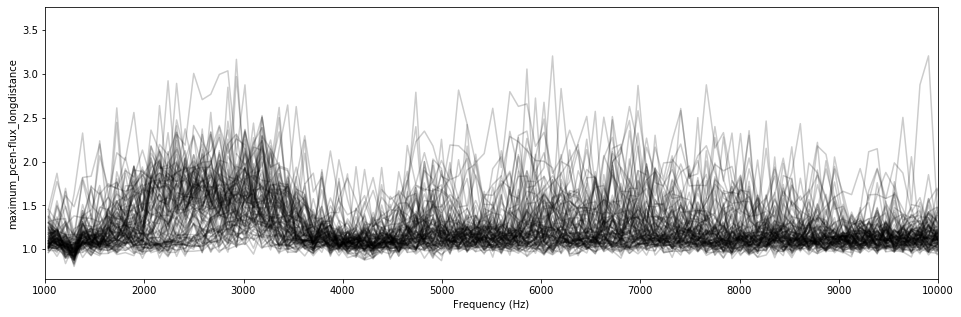

In [54]:
feature_str = 'maximum_pcen-flux_longdistance'
X_list = []




   
    
    
     
        
          
for X_dict in X_dicts:
    X_list.append(X_dict[feature_str])
X = np.array(X_list)

plt.figure(figsize=(16, 5))
plt.plot(
    librosa.fft_frequencies(sr=sr, n_fft=n_fft)[bin_start:bin_stop],
    X[:, bin_start:bin_stop].T,
    alpha=0.2, color='k');
plt.xlim(1000, 10000)
plt.xlabel("Frequency (Hz)")
plt.ylabel(feature_str)

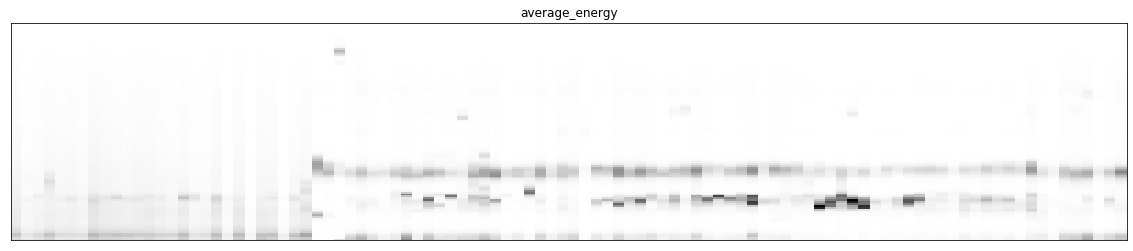

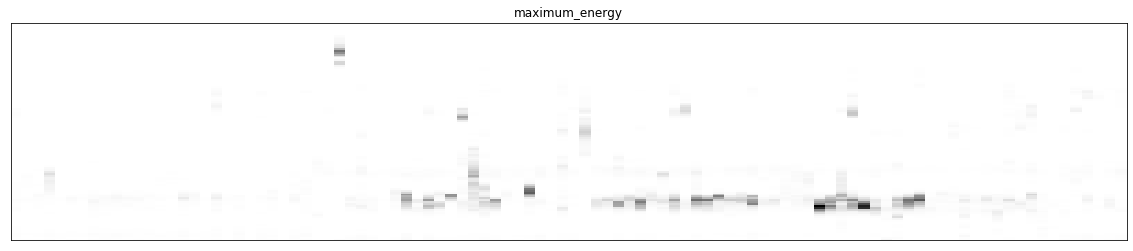

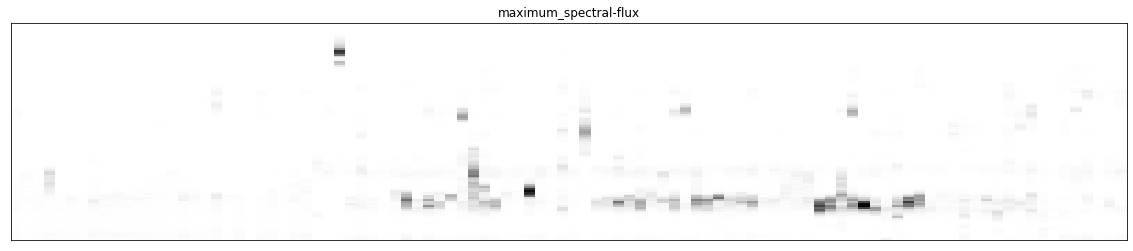

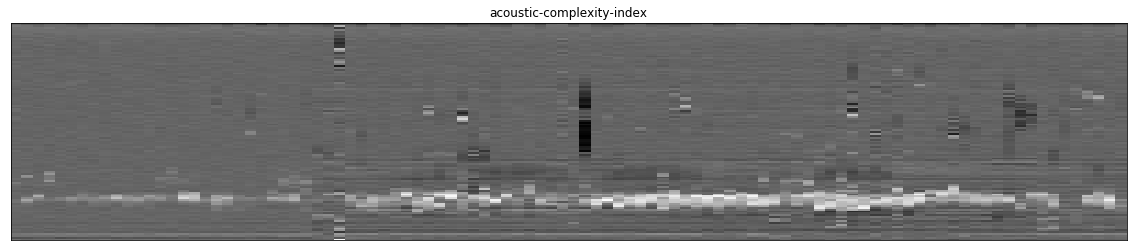

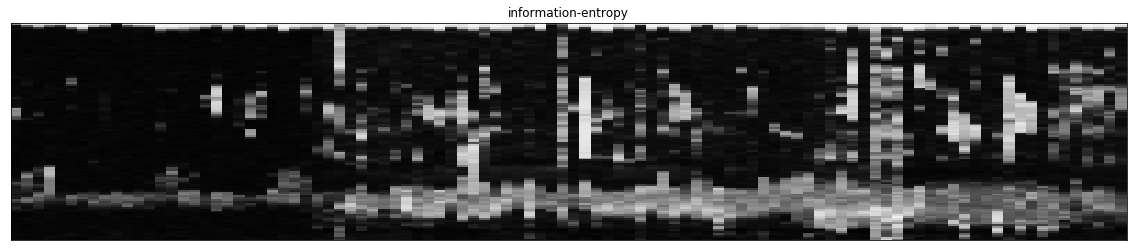

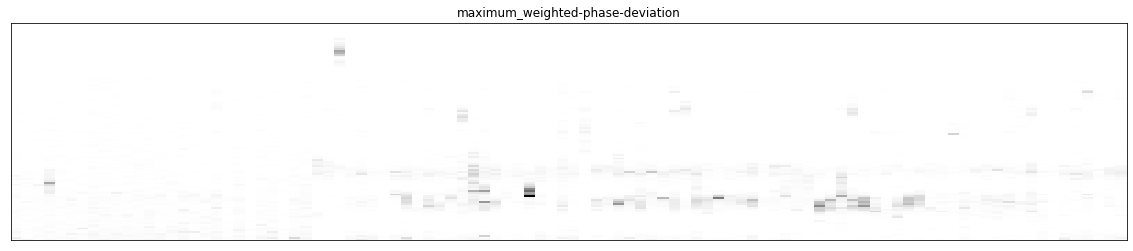

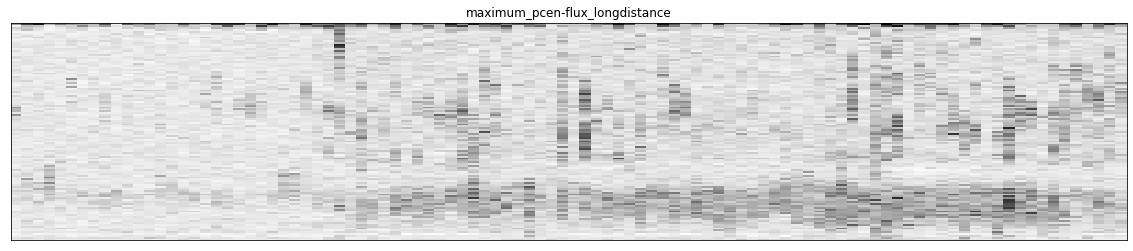

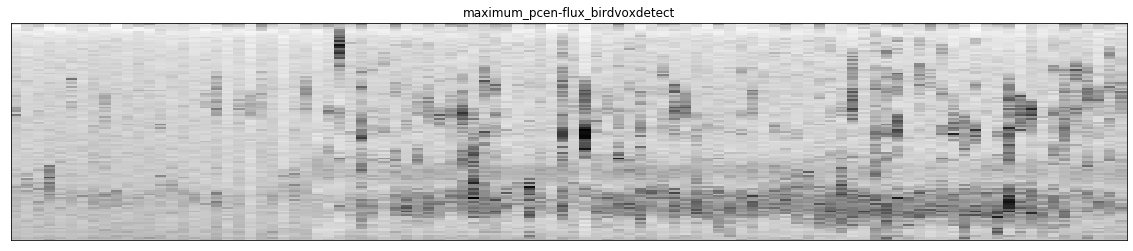

In [68]:
feature_strs = ['average_energy',
 'maximum_energy',
 'maximum_spectral-flux',
 'acoustic-complexity-index',
 'information-entropy',
 'maximum_weighted-phase-deviation',
 'maximum_pcen-flux_longdistance',
 'maximum_pcen-flux_birdvoxdetect',
 'maximum_pcen_longdistance',
 'maximum_pcen_birdvoxdetect']

for feature_str in feature_strs[:8]:
    X_list = []

    for X_dict in X_dicts:
        X_list.append(X_dict[feature_str])
    
    X = np.array(X_list)
    plt.figure(figsize=(20, 4))
    specshow(X[:, bin_start:bin_stop].T, cmap='gray_r')
    plt.title(feature_str)

In [62]:
X.shape

(100, 129)